In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

In [15]:
import pandas as pd
import numpy as np
from datetime import timedelta
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

## data preprocessing

In [11]:
df = pd.read_csv('survival_raw_data.csv')

In [26]:
df['duration'] = ((pd.to_datetime(df['end']) - pd.to_datetime(df['start']))/timedelta(days=1)).map(np.floor) + 1

In [13]:
df.head()

,customer_id,start,end,cohort,stopped,duration
0,0,2018-09-07 05:03:03.090,2019-01-25 06:10:01.913,Strictly defined,True,140.0
1,1,2018-09-07 05:03:03.278,2018-11-02 05:03:39.237,Strictly defined,True,56.0
2,2,2018-09-07 05:03:03.262,2019-06-14 05:15:38.497,Strictly defined,True,280.0
3,3,2018-09-07 05:03:03.199,2018-11-30 06:04:44.712,Strictly defined,True,84.0
4,4,2018-09-07 05:03:03.106,2019-09-20 05:18:05.638,Strictly defined,True,378.0


## Overall survival rate

Text(0, 0.5, 'Survival rate')

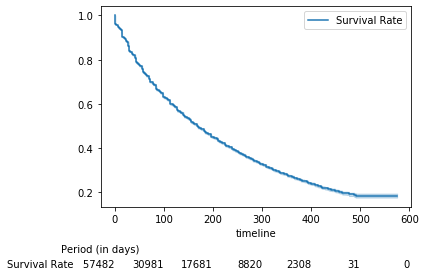

In [27]:
kmf = KaplanMeierFitter()
# plt.figure(figsize=(8,5))
kmf.fit(df["duration"].map(round), df["stopped"], label='Survival Rate')
kmf.plot(at_risk_counts=True)
plt.xlabel('Period (in days)')
plt.ylabel('Survival rate')

In [28]:
kmf.survival_function_

,Survival Rate
timeline,
0.0,1.000000
1.0,0.961936
2.0,0.959710
3.0,0.958010
4.0,0.956010
...,...
515.0,0.185892
519.0,0.185892
533.0,0.185892


## Actual calculation

In [ ]:
at_risk = pd.DataFrame(pd.Series(
    np.arange(dates_all['duration'].min(), dates_all['duration'].max())
).apply(lambda x:risk_count(x))).reset_index().rename(
    columns={'index':'duration', 0:'at_risk'}
)
at_risk['duration'] = at_risk['duration']+1

In [34]:
def risk_count(df,x):
    return (df['duration']>=x).sum()

In [39]:
at_risk = pd.Series(
    np.arange(df['duration'].min(), df['duration'].max())
).apply(lambda x:risk_count(df,x)).reset_index().rename(
    columns={'index':'duration', 0:'at_risk'}
)
at_risk['duration'] = at_risk['duration']+1

In [40]:
death = df.groupby('duration')['stopped'].sum().reset_index()

In [42]:
risk_death = at_risk.merge(death, how='left')

In [44]:
risk_death['stopped'] = risk_death['stopped'].fillna(0)

In [45]:
risk_death['surv_prob'] = 1 - risk_death['stopped']/risk_death['at_risk']
risk_death['cum_surv_rate'] = risk_death['surv_prob'].cumprod()

In [47]:
risk_death

,duration,at_risk,stopped,surv_prob,cum_surv_rate
0,1,57482,2188.0,0.961936,0.961936
1,2,54889,127.0,0.997686,0.959710
2,3,54740,97.0,0.998228,0.958010
3,4,54622,114.0,0.997913,0.956010
4,5,54491,96.0,0.998238,0.954326
...,...,...,...,...,...
569,570,1,0.0,1.000000,0.185892
570,571,1,0.0,1.000000,0.185892
571,572,1,0.0,1.000000,0.185892
572,573,1,0.0,1.000000,0.185892


Only consider those who are mature:

In [48]:
risk_death['cum_death'] = risk_death['stopped'].cumsum()
risk_death['mature_survival_rate'] = 1 - risk_death['cum_death']/(risk_death['cum_death'].shift(1).fillna(0)+risk_death['at_risk'])

## Survival rate by cohort

Text(0, 0.5, 'survival rate')

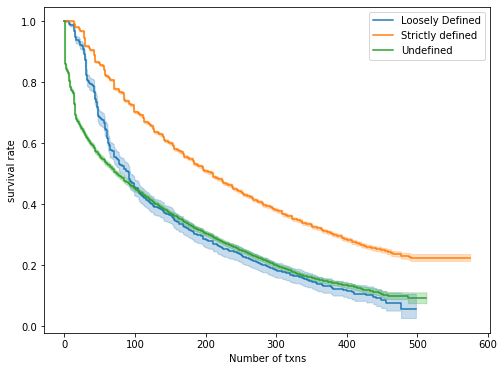

In [30]:
from lifelines import KaplanMeierFitter
# ax = plt.subplot(111)
kmf = KaplanMeierFitter()

plt.figure(figsize=(8,6))
for name, grouped_df in df.groupby('cohort'):
    kmf.fit(grouped_df["duration"], grouped_df["stopped"], label=name)
    kmf.plot()

plt.xlabel('Number of txns')
plt.ylabel('survival rate')